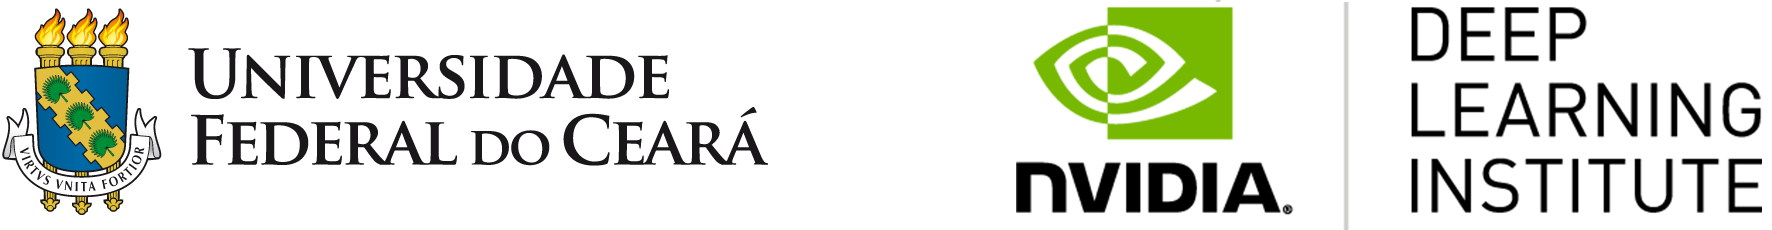

## Classificação de Imagens com o Dataset Médico (Pneumonia)

Disciplina: Sistema Distribuidos

Aluno: Ernesto Gurgel Valente Neto

Prof. Dr. Julio Anjos

## Objetivos

## Solução: Redes Neurais Convolucionais (CNNs) - Deep Learning

As Redes Neurais Convolucionais (CNNs) são especialmente boas para analisar dados visuais, como imagens médicas, devido às suas características e funcionalidades únicas. Aqui estão algumas justificativas para usar uma CNN em aplicações médicas:

1. **Reconhecimento de Padrões Espaciais:** CNNs são projetadas para reconhecer padrões espaciais em imagens através do uso de filtros e camadas de convolução. Isso é especialmente útil na análise de imagens médicas onde certos padrões ou características nas imagens (por exemplo, a forma e a textura de uma massa tumoral em uma imagem de ressonância magnética) são indicativos de uma condição médica.

2. **Invariância à Translação:** CNNs são invariantes à translação, o que significa que podem reconhecer um padrão independentemente de onde ele apareça na imagem. Isso é útil na análise de imagens médicas, pois a localização exata de uma anormalidade pode variar entre os pacientes.

3. **Redução de Dimensionalidade:** CNNs podem efetivamente reduzir a dimensionalidade dos dados, concentrando-se nas características mais importantes e ignorando as menos importantes. Isso é especialmente útil ao lidar com imagens médicas de alta resolução que podem ter uma alta dimensionalidade.

4. **Desempenho Superior:** Em muitos casos, CNNs demonstraram desempenho superior em comparação com outras técnicas de aprendizado de máquina na classificação de imagens e detecção de objetos. Na medicina, isso pode se traduzir em diagnósticos mais precisos e previsões de prognósticos.

5. **Automatização da extração de características:** Diferentemente dos métodos tradicionais de visão computacional, as CNNs aprendem automaticamente as características a partir dos dados de treinamento. Isso elimina a necessidade de engenharia manual de características, que pode ser demorada e requer conhecimento de especialistas.

Por estas razões, as CNNs têm sido amplamente utilizadas em diversas aplicações de imagem médica, como detecção de câncer, análise de imagens de ressonância magnética, ultrassom, tomografia computadorizada e muito mais.

## Dataset Médico (Pneumologia)

 Conjunto de dados de imagens validadas de OCT e radiografia de tórax descritas e analisadas em "Classificação baseada em aprendizado profundo e encaminhamento de doenças humanas tratáveis". As imagens OCT são divididas em um conjunto de treinamento e um conjunto de teste de pacientes independentes. As imagens OCT são rotuladas como (doença)-(ID do paciente randomizado)-(número da imagem deste paciente) e divididas em 4 diretórios: CNV, DME, DRUSEN e NORMAL.


Reconhecimento
[Dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2)

License: CC BY 4.0
[Citation](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

[DOI](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)


## GPU
Ativiação e Validação das GPU e Memoria adicional

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 23 18:36:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Carregando as bibliotecas (pyhton)

In [ ]:
#Importação das bibliotecas
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Carregando dados de serviço da nuvem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path = "/content/drive/MyDrive/archive/chest_xray"

In [ ]:
all_normal = glob(os.path.join(main_path, "train", "NORMAL", "*.jpeg")) + \
             glob(os.path.join(main_path, "test", "NORMAL", "*.jpeg")) + \
             glob(os.path.join(main_path, "val", "NORMAL", "*.jpeg"))

all_pneumonia = glob(os.path.join(main_path, "train", "PNEUMONIA", "*.jpeg")) + \
                glob(os.path.join(main_path, "test", "PNEUMONIA", "*.jpeg")) + \
                glob(os.path.join(main_path, "val", "PNEUMONIA", "*.jpeg"))


Este código está criando três DataFrames do pandas (**df_train, df_test e df_valid**)

a partir das listas de imagens de treinamento, teste e validação que foram previamente definidas.

Cada DataFrame tem duas colunas:

* A coluna 'class' indica a classe da imagem. As imagens são rotuladas como
* 'Normal' ou 'Pneumonia'. A expressão `['Normal'] * len(train_normal)` cria uma lista que contém a string 'Normal' repetida o número de vezes igual ao tamanho de `train_normal`, que é o número de imagens normais no conjunto de treinamento. O mesmo é feito para a classe 'Pneumonia' com `['Pneumonia'] * len(train_pneumonia)`. As duas listas são então concatenadas juntas com o operador `+`, resultando em uma lista que tem a string 'Normal' para cada imagem normal e a string 'Pneumonia' para cada imagem com pneumonia.
*  A coluna 'image' contém os caminhos para as imagens. Similarmente à coluna 'class', os caminhos para as imagens normais e de pneumonia são concatenados juntos para formar uma única lista.

In [ ]:
df_all = pd.DataFrame({
    'class': ['Normal'] * len(all_normal) + ['Pneumonia'] * len(all_pneumonia),
    'image': all_normal + all_pneumonia
})

Separando os dataset em conjuntos de dados de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

#Embaralhamento do dataset antes da divisão
df_all = df_all.sample(frac=1).reset_index(drop=True)

# Primeiro, dividimos o conjunto de dados em treinamento (80%) e teste (20%)
df_train, df_test = train_test_split(df_all, test_size=0.2, stratify=df_all['class'], random_state=42)

# Então dividimos o conjunto de treinamento em treinamento (80%) e validação (20%)
df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train['class'], random_state=42)

# Redefinindo o índice para poder validar os dados divididos
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Explorando os dados do MÉDICOS

O método shape retorna uma tupla representando as dimensões do DataFrame. A primeira entrada da tupla é o **número de linhas** e a **segunda é o número de colunas**.

* df_train.shape retorna o formato do DataFrame de treinamento, que contém as imagens e rótulos que serão usados para treinar o modelo.
* df_test.shape retorna o formato do DataFrame de teste, que contém as imagens e rótulos que serão usados para avaliar a performance do modelo depois que ele foi treinado.
* df_valid.shape retorna o formato do DataFrame de validação, que contém as imagens e rótulos que podem ser usados para ajustar os parâmetros do modelo durante o treinamento (embora a maneira como esses conjuntos de dados são usados possa variar dependendo da abordagem específica de modelagem usada).

In [ ]:
print("data frame:\n", pd.concat([df_all.head(5), df_all.tail(5)]))

data frame:
           class                                              image
0     Pneumonia  /content/drive/MyDrive/archive/chest_xray/test...
1     Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
2     Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
3        Normal  /content/drive/MyDrive/archive/chest_xray/trai...
4        Normal  /content/drive/MyDrive/archive/chest_xray/trai...
5851  Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
5852     Normal  /content/drive/MyDrive/archive/chest_xray/trai...
5853  Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
5854     Normal  /content/drive/MyDrive/archive/chest_xray/trai...
5855     Normal  /content/drive/MyDrive/archive/chest_xray/trai...


In [ ]:
print("df_train: ", df_train.shape)
print("df_test: ", df_test.shape)
print("df_valid: ", df_valid.shape)

df_train:  (3747, 2)
df_test:  (1172, 2)
df_valid:  (937, 2)


A função dtypes em pandas retorna uma série com o tipo de dado de cada coluna. O índice da série é o nome da coluna.

In [ ]:
print("df_train", df_train.dtypes)
print("\n df_test:\n", df_test.dtypes)
print("\ndf_valid:\n", df_valid.dtypes)

df_train class    object
image    object
dtype: object

 df_test:
 class    object
image    object
dtype: object

df_valid:
 class    object
image    object
dtype: object


In [ ]:
df_all

,class,image
0,Pneumonia,/content/drive/MyDrive/archive/chest_xray/test...
1,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
2,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
3,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
4,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
...,...,...
5851,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
5852,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
5853,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
5854,Normal,/content/drive/MyDrive/archive/chest_xray/trai...


## Explorando os dados do médicos / Definição de funções de plot das imagens

As especificações a seguir representam o uso da função (plot_images) ao qual imprime imagens.

def plot_images(df, start_index, num_images):


*   df = é qual o dataframe será passado plotagem.
*   start_index = é a posição inicial do array.
*   num_images = é quantidade de imagens que serão plotadas








In [ ]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
def plot_images(df, start_index, num_images):
    fig = plt.figure(figsize=(10, 10))
    if start_index + num_images > len(df):
        num_images = len(df) - start_index
    for i in range(num_images):
        image_path = df['image'][start_index + i]
        image_class = df['class'][start_index + i] #Pegando a classe da imagem
        try:
            image = Image.open(image_path)
            ax = fig.add_subplot(num_images, 1, i+1)
            ax.imshow(image, cmap='gray')
            ax.set_title(f'Image {start_index + i}, Class: {image_class}')  #Imprimindo o titulo da classe da imagem
            ax.axis('off')
        #Excessão e tratamento de excessão em um acesso invalido.
        except (IOError, OSError) as e:
            print(f"Erro ao carregar imagem {start_index + i}: {e}")

    plt.tight_layout()
    plt.show()

#from PIL import Image

# Supondo que 'image' na df_train contenha o caminho da imagem
#image_path = df_train['image'][0]  # pega o caminho da primeira imagem do DataFrame

# Carregar a imagem do arquivo
#img = Image.open(image_path)

# Imprimir as dimensões da imagem
#print('Width:', img.width)
#print('Height:', img.height)

# Exibir a imagem
#img.show()


### Analise das imagens médicas da classe "Normal"

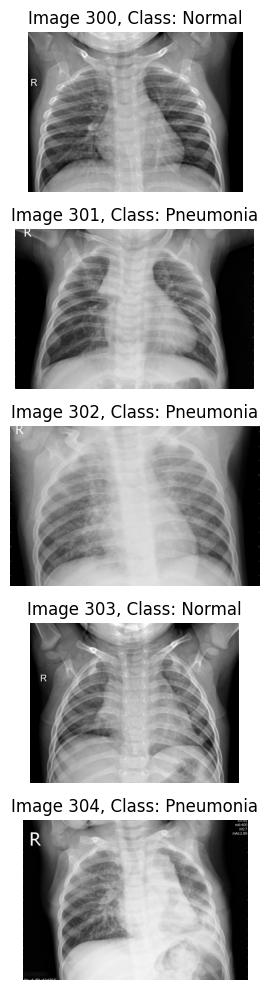

In [ ]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
plot_images(df_all, start_index=300, num_images=5)

### Analise das imagens médicas da classe "Pneumonia"

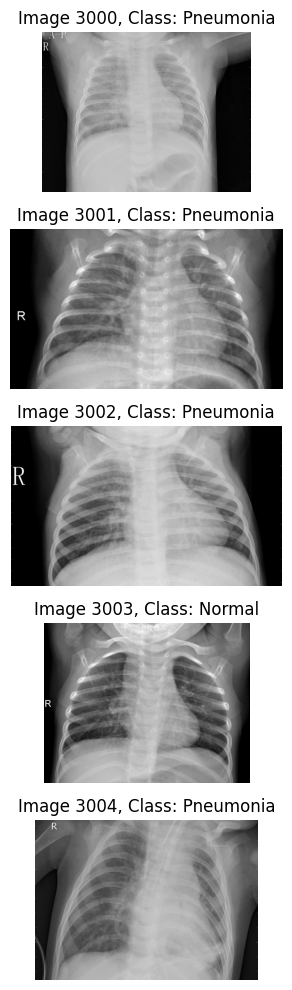

In [ ]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
plot_images(df_all, start_index=3000, num_images=5)

### Explorando os dados do médicos / Definição de funções de distribuição

As especificações a seguir representam o uso da função (plot_images) ao qual imprime imagens. A função def plot_class_distribution(df):


*   Apresenta  a a distribuição do plot_class_distribution("DATA FRAME SELECIONADO")

In [ ]:
def plot_class_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='class')
    plt.title('Distribuição das Classes')
    plt.show()

### Dataframe de treinamento

Analise da distribuição dos dados de treinamento das classes:

*   Normal; e
*   Pneumonia;

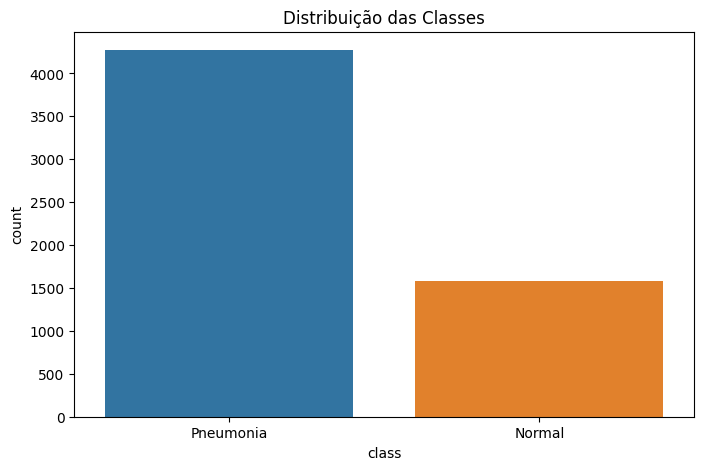

In [ ]:
plot_class_distribution(df_all)

### Dataframe de Validação

Analise da distribuição dos dados de validação das classes:

*   Normal; e
*   Pneumonia;



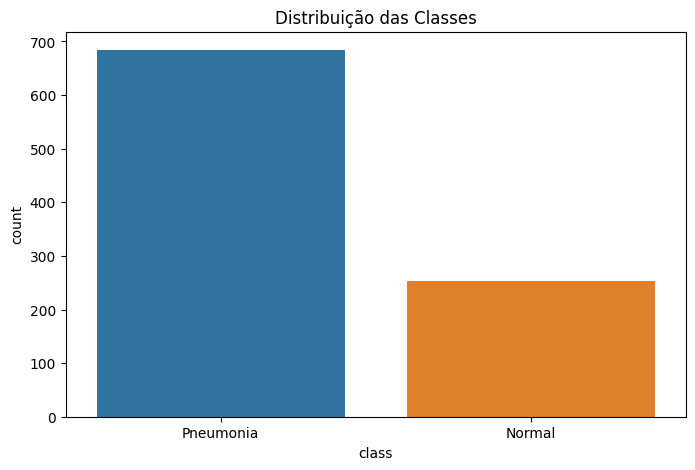

In [ ]:
plot_class_distribution(df_valid)

### Dataframe de Teste

Analise da distribuição dos dados de teste das classes:

*   Normal; e
*   Pneumonia;



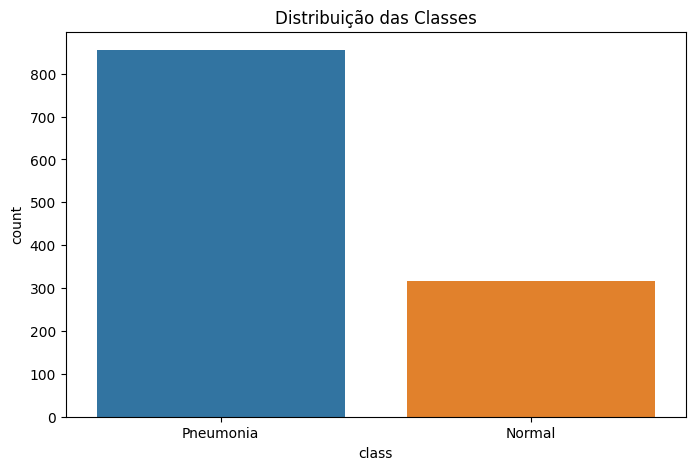

In [ ]:
plot_class_distribution(df_test)

# Preparação dos Dados para o Treinamento

Embora os modelos de aprendizado profundo sejam totalmente capazes de lidar com dados multidimensionais, como é o caso de imagens, a aplicação da operação de [reshape](https://www.tensorflow.org/api_docs/python/tf/reshape) para "achatar" as imagens e transformá-las em uma única matriz contínua de pixels é uma prática comum. Essa operação simplifica a estrutura de dados de entrada e pode facilitar o processo de treinamento, especialmente ao lidar com modelos mais simples ou ao iniciar a modelagem.

* No nosso caso específico, uma imagem de dimensões 28x28 pixels é transformada em uma matriz unidimensional de 784 elementos (28x28 = 784). Esta transformação é comumente referida como "nivelamento" da imagem.

* A função `reshape` é uma ferramenta poderosa neste processo, permitindo que reformulemos a estrutura dos nossos dados para se adequar às necessidades do nosso modelo. A operação de reshape é crucial para garantir que os nossos dados de entrada estejam na forma correta antes de alimentá-los no modelo.

Em nosso caso de classificação de imagens, temos duas categorias: 'Normal' e 'Pneumonia'. A ideia é que nosso modelo de aprendizado de máquina entenda que, para uma imagem específica, ou ela é **'Normal' ou 'Pneumonia'**, não existe um "quase Normal" ou "quase Pneumonia".

O atual rótulo das imagens é uma designação de **'Normal' ou 'Pneumonia'**. Como essas categorias formam uma escolha binária, o modelo pode pensar erroneamente que está "próximo" de acertar se adivinhar de forma errada.

Para evitar isso, utilizaremos  a **codificação categórica**. Esta transformação muda os rótulos para que cada rótulo seja uma coleção de todas as categorias possíveis, com o verdadeiro rótulo da imagem marcado como verdadeiro.

Por exemplo, para as categorias 'Normal' e 'Pneumonia', depois da codificação categórica, teríamos algo assim para uma imagem 'Normal':

* 'Normal': Falso (1)
* 'Pneumonia': Verdadeiro (0)

Isso ajuda o modelo a entender que ou uma imagem é **'Normal' ou 'Pneumonia', sem qualquer conceito de proximidade entre as categorias**.

Esse processo é representado pela codificação das label `labels.append(1 if label == 'Pneumonia' else 0)´

In [ ]:
# Função para carregar e processar as imagens
def load_and_process_images(df, image_size=(28, 28)):
    images = []
    labels = []
    total_images = df.shape[0]
    for i, (image_path, label) in enumerate(zip(df['image'], df['class'])):
        # Carrega a imagem com a biblioteca PIL
        img = Image.open(image_path)
        #Redimensiona a imagem para 28x28 pixels usando o método resize. (28 x 28)
        img = img.resize(image_size)
        #Converte a imagem para escala de cinza com o método convert('L'). Isso é feito porque as imagens em escala de cinza são mais simples de lidar
        #(uma única camada de intensidades de pixel, em vez de três camadas de cores em imagens coloridas) e são suficientes para muitas tarefas de processamento
        #de imagem e aprendizado de máquina.
        img = img.convert('L')
        # Converte a imagem para um array NumPy
        img_array = np.array(img)
        # Normaliza os pixels (0-255) para o intervalo 0-1
        img_array = img_array / 255.0
        #Achatando a imagem usando reshape(-1). Isso transforma a matriz 2D em uma matriz 1D (um vetor) de elementos.
        #Como o tamanho da imagem é 28x28 pixels, o vetor terá 784 elementos.
        img_array = img_array.reshape(-1)
        # Adiciona ao conjunto de imagens
        images.append(img_array)
        # Converte rótulo e adiciona ao conjunto de rótulos (Conersão de rotulos binária 1 Pneumonia 0 Normal)
        labels.append(1 if label == 'Pneumonia' else 0)

        # Mostrando o progresso
        if (i+1) % 100 == 0 or i+1 == total_images:
            print(f'Processando {i+1} de {total_images} imagens ({(i+1)/total_images*100:.2f}%)')

    return np.array(images), np.array(labels)

### Transformação dos dados

Width: 1974
Height: 2175


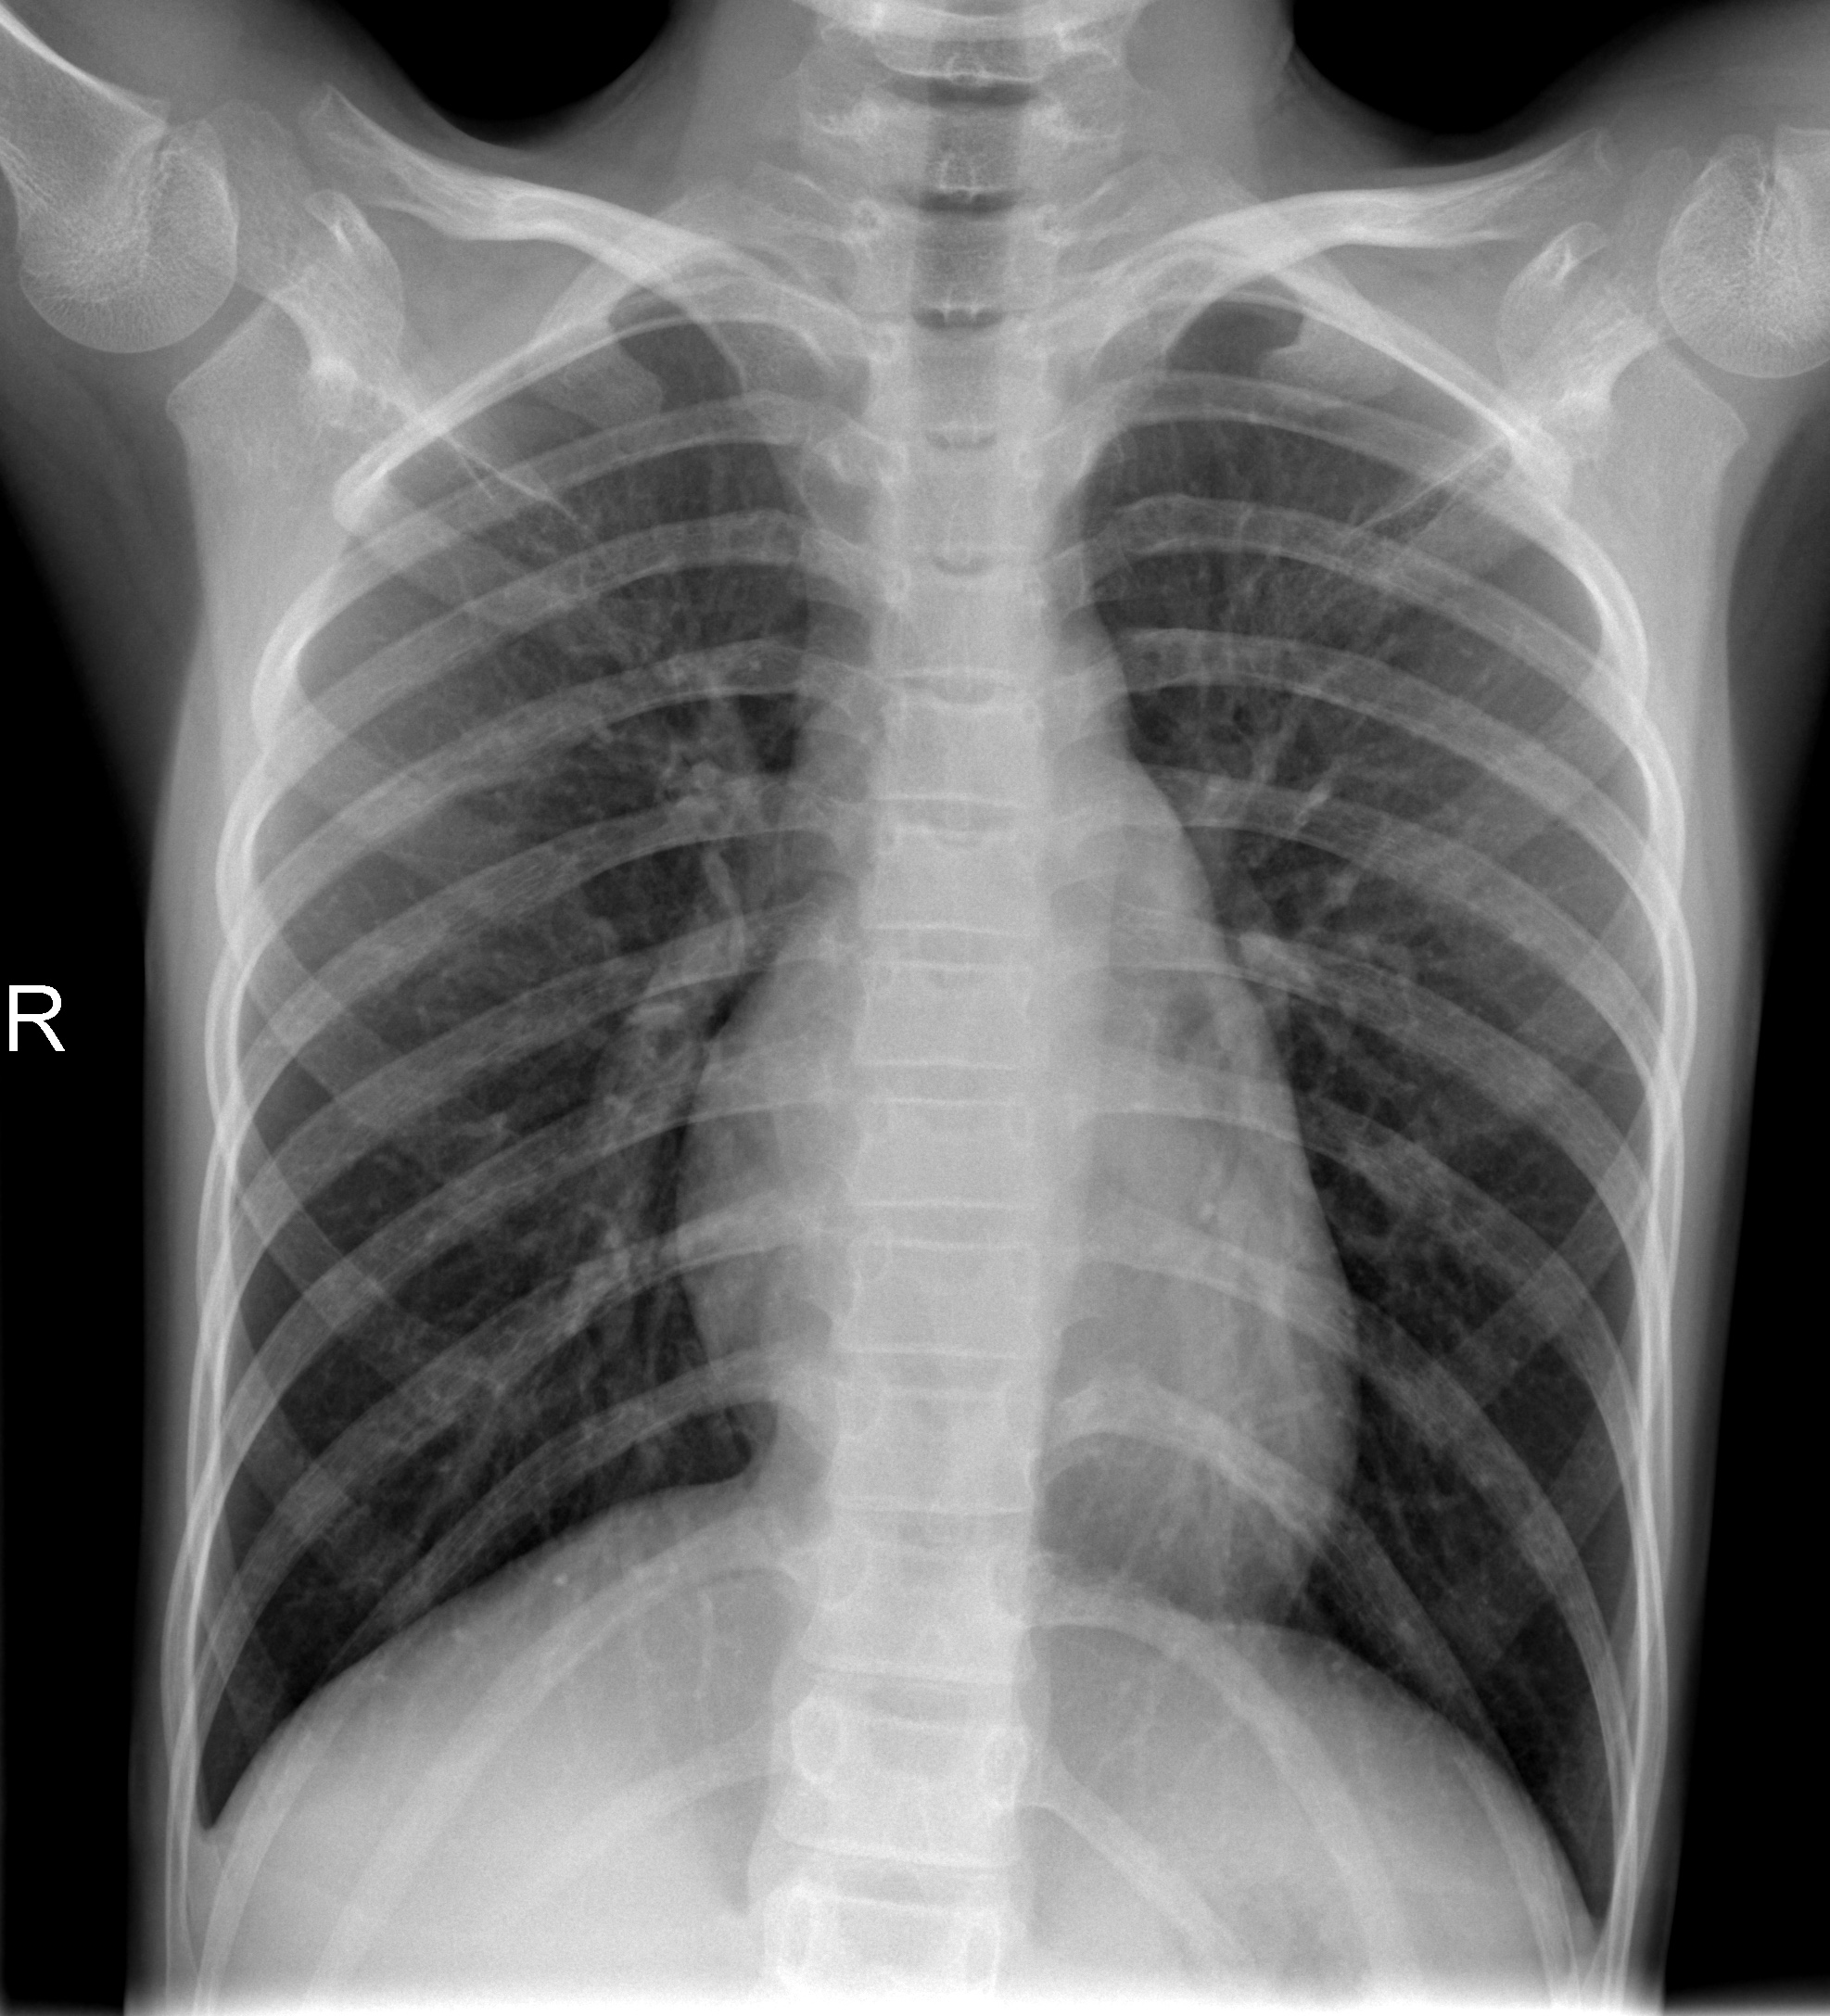

In [ ]:
from PIL import Image

# Supondo que 'image' na df_train contenha o caminho da imagem
image_path = df_train['image'][0]  # pega o caminho da primeira imagem do DataFrame

# Carregar a imagem do arquivo
img = Image.open(image_path)

# Imprimir as dimensões da imagem
print('Width:', img.width)
print('Height:', img.height)

# Exibir a imagem
img.show()


In [ ]:
print("Processamento dos Dados de Treinamento:\n")
# Carregando e processando as imagens e rótulos de treinamento
x_train, y_train = load_and_process_images(df_train)
#Redimensionamento para imagem 28x28
#x_train, y_train = load_and_process_images(df_train, image_size=(28, 28))


Processamento dos Dados de Treinamento:

Processando 100 de 3747 imagens (2.67%)
Processando 200 de 3747 imagens (5.34%)
Processando 300 de 3747 imagens (8.01%)
Processando 400 de 3747 imagens (10.68%)
Processando 500 de 3747 imagens (13.34%)
Processando 600 de 3747 imagens (16.01%)
Processando 700 de 3747 imagens (18.68%)
Processando 800 de 3747 imagens (21.35%)
Processando 900 de 3747 imagens (24.02%)
Processando 1000 de 3747 imagens (26.69%)
Processando 1100 de 3747 imagens (29.36%)
Processando 1200 de 3747 imagens (32.03%)
Processando 1300 de 3747 imagens (34.69%)
Processando 1400 de 3747 imagens (37.36%)
Processando 1500 de 3747 imagens (40.03%)
Processando 1600 de 3747 imagens (42.70%)
Processando 1700 de 3747 imagens (45.37%)
Processando 1800 de 3747 imagens (48.04%)
Processando 1900 de 3747 imagens (50.71%)
Processando 2000 de 3747 imagens (53.38%)
Processando 2100 de 3747 imagens (56.04%)
Processando 2200 de 3747 imagens (58.71%)
Processando 2300 de 3747 imagens (61.38%)
Proce

In [ ]:
print("\nProcessamento dos Dados de Validação:\n")
# Carregando e processando as imagens e rótulos de validação
x_valid, y_valid = load_and_process_images(df_valid)
#Redimensionamento para imagem 28x28
#x_valid, y_valid = load_and_process_images(df_valid, image_size=(28, 28))



Processamento dos Dados de Validação:

Processando 100 de 937 imagens (10.67%)
Processando 200 de 937 imagens (21.34%)
Processando 300 de 937 imagens (32.02%)
Processando 400 de 937 imagens (42.69%)
Processando 500 de 937 imagens (53.36%)
Processando 600 de 937 imagens (64.03%)
Processando 700 de 937 imagens (74.71%)
Processando 800 de 937 imagens (85.38%)
Processando 900 de 937 imagens (96.05%)
Processando 937 de 937 imagens (100.00%)


In [ ]:
print("\nProcessamento dos Dados de teste:\n")
# Carregando e processando as imagens e rótulos de teste
x_test, y_test = load_and_process_images(df_test)
#Redimensionamento para imagem 28x28
#x_test, y_test = load_and_process_images(df_test, image_size=(28, 28))


Processamento dos Dados de teste:

Processando 100 de 1172 imagens (8.53%)
Processando 200 de 1172 imagens (17.06%)
Processando 300 de 1172 imagens (25.60%)
Processando 400 de 1172 imagens (34.13%)
Processando 500 de 1172 imagens (42.66%)
Processando 600 de 1172 imagens (51.19%)
Processando 700 de 1172 imagens (59.73%)
Processando 800 de 1172 imagens (68.26%)
Processando 900 de 1172 imagens (76.79%)
Processando 1000 de 1172 imagens (85.32%)
Processando 1100 de 1172 imagens (93.86%)
Processando 1172 de 1172 imagens (100.00%)


### Validação da transformação

Nessa etapa verificamos se os dataframes de treinamento e teste foram corretamente transformados.


In [ ]:
#O modelo espera uma entrada de shape (None, 28, 28, 1)
#(que é o formato para uma imagem em escala de cinza de 28x28), em vez de uma entrada de shape (None, 784).
#Então vamos achatalas os vetores de 784 elementos, para estarem na forma de matrizes 28x28.
# Remodelando os dados de entrada para a forma correta
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)

In [ ]:
x_train.shape

(3747, 28, 28, 1)

In [ ]:
x_train[0]

array([[[0.        ],
        [0.07843137],
        [0.25882353],
        [0.35294118],
        [0.4       ],
        [0.38431373],
        [0.43921569],
        [0.51764706],
        [0.5254902 ],
        [0.61176471],
        [0.67843137],
        [0.80392157],
        [0.87058824],
        [0.81568627],
        [0.82745098],
        [0.85490196],
        [0.81960784],
        [0.74509804],
        [0.66666667],
        [0.61176471],
        [0.56470588],
        [0.4       ],
        [0.35294118],
        [0.50980392],
        [0.4745098 ],
        [0.28627451],
        [0.17254902],
        [0.03137255]],

       [[0.        ],
        [0.05490196],
        [0.24705882],
        [0.32156863],
        [0.36862745],
        [0.44705882],
        [0.48235294],
        [0.5254902 ],
        [0.56470588],
        [0.55294118],
        [0.59215686],
        [0.69411765],
        [0.79215686],
        [0.77254902],
        [0.77647059],
        [0.8       ],
        [0.7372549 ],
        

Agora podemos ver que os valores são todos valores de ponto flutuante entre **0.0 e 1.0**:

In [ ]:
x_train.dtype

dtype('float64')

In [ ]:
x_train.min()

0.0

In [ ]:
x_train.max()

1.0

In [ ]:
# Vamos pegar as primeiras 5 imagens
first_5_images = x_train[:5]

# Transpor para que cada imagem seja uma coluna e fique mais vacil de visualizar a transformação
first_5_images_transposed = np.transpose(first_5_images)

# Imprimir cada linha
for row in first_5_images_transposed:
    print(row)

In [ ]:
y_train[0:9]

Validação do Array Validação da Etapa de Encodificação de
* 0 para normal; e
* 1 para Pneumonia;
* Validação Conforme Array **"y_train[0:9]"** na linha anterior.

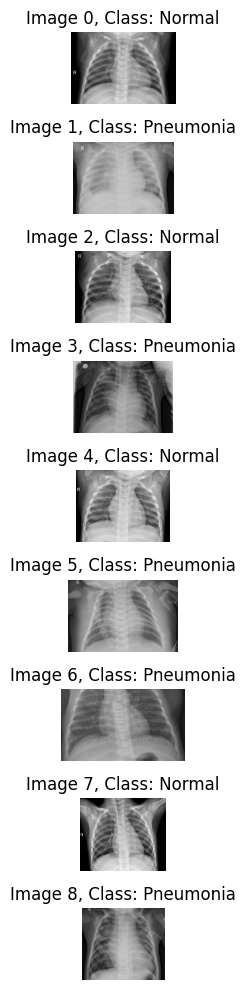

In [ ]:
plot_images(df_train, start_index=0, num_images=9)

# Criação do Modelo

Com os dados prontos, construiremos um modelo básico composto por camadas. O modelo tem 3 partes:
* Camada de entrada: recebe os dados no formato esperado.
* Camadas ocultas: formadas por neurônios que afetam a estimativa da rede através de seus pesos, valores ajustados ao longo do treinamento.
* Camada de saída: representa a estimativa da rede para uma entrada específica.

Usamos a classe Dense do Keras para criar uma camada densamente conectada, onde cada neurônio afeta todos os da próxima camada. Definimos o número de neurônios com o argumento `units`. A função de ativação `relu` permite que a rede faça suposições complexas sobre os dados. `input_shape` especifica o formato dos dados de entrada.

Por fim, adicionamos uma camada de saída com função de ativação `softmax`, resultando em valores de probabilidade entre 0 e 1 que somam 1. Para a nossa tarefa de classificar uma imagem em 10 categorias possíveis, teremos 10 saídas, cada uma representando a probabilidade da imagem pertencer a essa classe.

### Importando Modelo Pre-Treinado

Carregar a arquitetura do modelo ResNet50 com pesos pré-treinados no ImageNet

* Embora estas redes possam ser um bom ponto de partida, elas não foram especificamente projetadas para a tarefa de classificar doenças pulmonares.
* Os modelos pré-treinados possam acelerar o processo de treinamento e muitas vezes levar a melhores resultados, eles não são uma solução garantida para todas as tarefas e podem não sempre levar ao melhor desempenho possível.

In [ ]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Congelando o modelo

In [ ]:
base_model.trainable = False

### Compilando o Model

In [ ]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False
x = base_model(inputs, training=False)

# Flatten layer
x = layers.Flatten()(x)

# First dense layer
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.01)(x) # Reduced the dropout rate

# Second dense layer
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.01)(x) # Reduced the dropout rate

# Third dense layer
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.01)(x) # Reduced the dropout rate

# A Dense classifier with a single unit (binary classification)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)


In [ ]:
# Importante usar a binary crossentropy e binary accuracy, pois agora temos um problema de classificação binária
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

## Data Augmentation: Transferlearning

Data Augmentation para enviar ao modelo de Transferlearning. Nessa etapa realizamos o Data Augmentation adicionando dados dos dataset de treinamento:

* df_train;
* df_test; e
* df_valid;

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #Dessa forma, quando usamos rescale=1./255 estamos basicamente fazendo uma pré-processamento para normalizar nossas imagens
    #antes de alimentá-las para o treinamento da rede neural.
    rescale=1./255,
    #As imagens de raios-X e tomografia computadorizada do tórax podem variar com base em fatores como o ângulo da imagem ou a posição do paciente.
    #Ainda algo também pode ser visto nas fotos, porém valores conservadores devem ser adotados para tornar o modelo mais robusto e evitar
    #Confundir o modelo
    shear_range=0.1,
    #Improvavel que rotação de raio-X de pulmão seja diferente de zero. Pode se tentar ainda algo conservador como 5 a 10.
    # Porém é possivel ver nas imagens que existe uma variação do angulo do pulmão e não esta perfeitamente alinhado no eixo principal
    rotation_range=0.1,  # randomly rotate images in the range (degrees, 0 to 180)
    #Util testar visto que pode ser tirado o raio-x de diferentes distancias. E não existe uma normativa global a que distancia deve ser tirado o raio-x do paciente.
    #Apenas a distancia do tecnico é referenciada como recomendado. Logo a posição e distancia relativa do paciente pode ser diferente em diferentes locais
    #De coleta.
    zoom_range=0.1,  # Randomly zoom image
    #A localização do pulmão na imagem variar, mas em um contexto médico,a posição do pulmão provavelmente é bastante padronizada.
    #Mudanças bruscas podem alterar drasticamente o modelo, sugerivel uma abordagem mais conservadora.
    #Valor entre 0.02 ou 0.05
    width_shift_range=0.02,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.02,  # randomly shift images vertically (fraction of total height)
    #Pode ser util pela qualidade dos pulmões representarem dois horizontalmente e doenças e estados normais poderem ser melhor representados
    #De maneira espelhada na horizontal.
    horizontal_flip=True,  # randomly flip images horizontally
    #Essa opção é melhor desativada, confundiria o modelo um pulmão invertido
    vertical_flip=False, # Don't randomly flip images vertically
)

datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values
# Create data generators
ds_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)

ds_val = datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)

ds_test = datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1
)

Found 3747 validated image filenames belonging to 2 classes.
Found 937 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


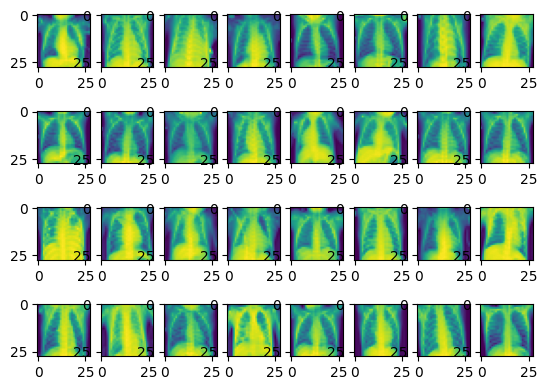

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

# Etapa de Treinamento do Modelo Transfelarning

Treinamento do modelo importado

In [ ]:
#history = model.fit(ds_train, steps_per_epoch=12, validation_data=ds_val, validation_steps=4, epochs=20)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Definindo o objeto de parada antecipada
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(ds_train,
                    steps_per_epoch=12,
                    validation_data=ds_val,
                    validation_steps=4,
                    epochs=50,
                    callbacks=[early_stopping])


Epoch 1/50
12/12 [==============================] - 8s 646ms/step - loss: 0.0804 - binary_accuracy: 0.9688 - val_loss: 0.1358 - val_binary_accuracy: 0.9766
Epoch 2/50
12/12 [==============================] - 7s 601ms/step - loss: 0.1102 - binary_accuracy: 0.9661 - val_loss: 0.1834 - val_binary_accuracy: 0.9766
Epoch 3/50
12/12 [==============================] - 6s 538ms/step - loss: 0.0550 - binary_accuracy: 0.9792 - val_loss: 0.2212 - val_binary_accuracy: 0.9375
Epoch 4/50
12/12 [==============================] - 7s 568ms/step - loss: 0.0842 - binary_accuracy: 0.9661 - val_loss: 0.2075 - val_binary_accuracy: 0.9688
Epoch 5/50
12/12 [==============================] - 7s 575ms/step - loss: 0.0856 - binary_accuracy: 0.9688 - val_loss: 0.2163 - val_binary_accuracy: 0.9375
Epoch 6/50
12/12 [==============================] - 7s 571ms/step - loss: 0.0508 - binary_accuracy: 0.9844 - val_loss: 0.1769 - val_binary_accuracy: 0.9531
Epoch 7/50
12/12 [==============================] - 7s 581ms/ste

### Plot de Treinamento

(0.0, 2.0)

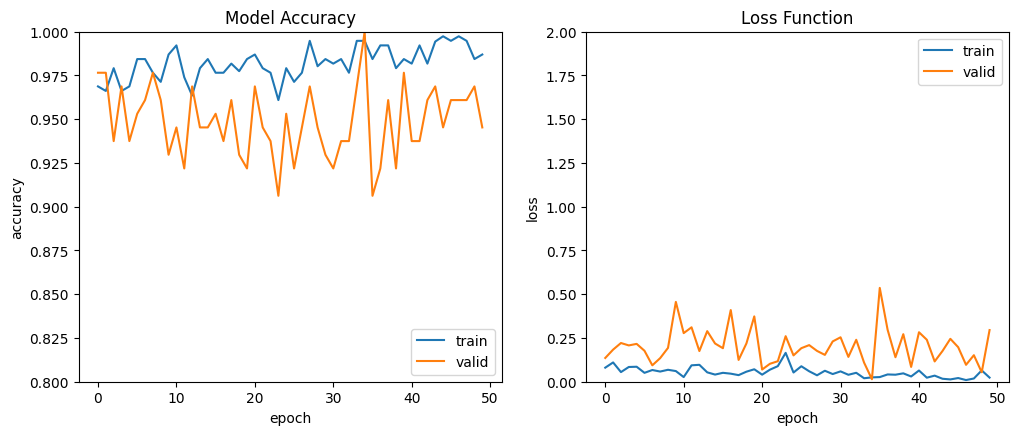

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.ylim(0.8, 1)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.ylim([0,2])

Ajuste Fino

Com os dados de treinamento, validação e o modelo preparados, é hora de ajustar o modelo. Esse processo, também chamado de treinamento, adapta o modelo aos dados. Usamos o método `fit` do Keras, que requer:

* Dados de treinamento e respectivos rótulos
* Número de iterações completas no conjunto de treinamento (épocas)
* Dados de validação ou teste e seus rótulos

Ao executar o treinamento, o modelo aprenderá e ajustará sua forma para melhor representar os dados.

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
history1 = model.fit(ds_train, steps_per_epoch=12, validation_data=ds_val, validation_steps=4, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?



12/12 [==============================] - 12s 555ms/step - loss: 0.0432 - binary_accuracy: 0.9844 - val_loss: 0.1797 - val_binary_accuracy: 0.9688
Epoch 2/10
12/12 [==============================] - 7s 547ms/step - loss: 0.0295 - binary_accuracy: 0.9896 - val_loss: 0.2025 - val_binary_accuracy: 0.9609
Epoch 3/10
12/12 [==============================] - 7s 573ms/step - loss: 0.0106 - binary_accuracy: 0.9948 - val_loss: 0.2133 - val_binary_accuracy: 0.9688
Epoch 4/10
12/12 [==============================] - 7s 585ms/step - loss: 0.0317 - binary_accuracy: 0.9870 - val_loss: 0.1261 - val_binary_accuracy: 0.9609
Epoch 5/10
12/12 [==============================] - 7s 594ms/step - loss: 0.0454 - binary_accuracy: 0.9818 - val_loss: 0.3118 - val_binary_accuracy: 0.9531
Epoch 6/10
12/12 [==============================] - 6s 537ms/step - loss: 0.0202 - binary_accuracy: 0.9922 - val_loss: 0.3115 - val_binary_accuracy: 0.9219
Epoch 7/10
12/12 [==============================] - 7s 584ms/step - loss: 

# Plotando os Resultados

(0.0, 0.15)

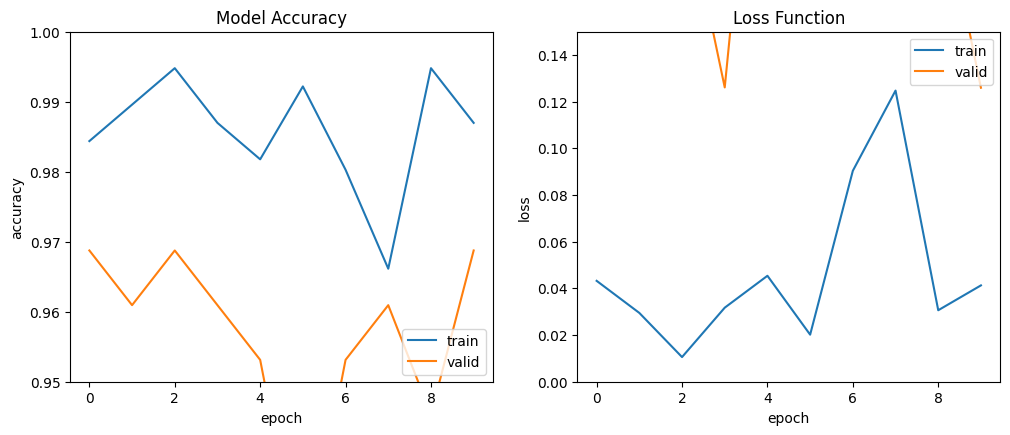

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history1.history['binary_accuracy'])
plt.plot(history1.history['val_binary_accuracy'])
plt.ylim(0.95, 1)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss Function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.ylim([0,0.15])

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Supondo que y_test são seus rótulos reais e y_score são as probabilidades de previsões do seu modelo.
x_test = x_test.reshape(-1, 28, 28, 1)
y_score = model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Criando o gráfico ROC com Plotly
trace0 = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc)
trace1 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random')

layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    showlegend=True
)

fig = go.Figure(data=[trace0, trace1], layout=layout)
fig.show()


37/37 [==============================] - 0s 3ms/step


In [ ]:
https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
https://keeeto.github.io/blog/bias_variance/

SyntaxError: ignored

### Observando a Acurácia (Accuracy)

Para cada uma das 10 épocas, observe as pontuações `accuracy` e `val_accuracy`. `precisão` indica o desempenho do modelo para a época em todos os dados de treinamento. `val_accuracy` indica o desempenho do modelo nos dados de validação, que, se você se lembra, não foi usado para treinar o modelo.

A modelo mandou muito bem! A precisão atingiu rapidamente perto de 100%, assim como a precisão da validação. Agora temos um modelo que pode ser usado para detectar e classificar com precisão imagens manuscritas.

O próximo passo seria usar esse modelo para classificar novas imagens manuscritas ainda não vistas. Isso é chamado de [inferência](https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/). Exploraremos o processo de inferência em um exercício posterior.

## Limpando a Memória

Antes de prosseguir, execute a célula a seguir para limpar a memória da GPU. Isso é necessário para passar para o próximo notebook.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)